In [3]:
import pickle
p = "/content/rmab_sequences.pkl"
with open(p,"rb") as f:
    d = pickle.load(f)
print("state dim:", len(d["state_cols"]))
print("n trajectories:", len(d["sequences"]))


state dim: 20
n trajectories: 24635


In [4]:
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 58.3 MB/s eta 0:00:00


In [5]:
import joblib, numpy as np
m = joblib.load("/content/behavior_model_lgbm_statecols_ISO.pkl")
print("behavior.classes_:", getattr(m, "classes_", None))
import numpy as np
probs = np.load("/content/behavior_propensity_probs_statecols.npy", allow_pickle=False)
print("propensities shape:", probs.shape)


behavior.classes_: [0 1 2]
propensities shape: (197080, 3)


In [6]:
import json
print(json.load(open("/content/ope_crossfit_summary.json")))
print(json.load(open("/content/policy_mix_selected_summary.json")))


{'temp': 0.2, 'clip': 5.0, 'rho_cap': 1000.0, 'gamma': 0.95, 'n_traj': 24635, 'dr_noncum_mean': 29.928138959989457, 'dr_noncum_ci_low': 29.75391647861781, 'dr_noncum_ci_high': 30.09618388177546, 'dr_cum_mean': 166.10688497408094, 'dr_cum_ci_low': 152.76943301686973, 'dr_cum_ci_high': 180.7447058859503, 'wis': 1.3743127716660637, 'wis_ci_low': 1.165274902153309, 'wis_ci_high': 1.6015027620804732, 'ess_traj': 124.50765544316492}
{'temp': 0.25, 'alpha': 0.2, 'tau': 0.0, 'clip': 3.0, 'gamma': 0.95, 'wis_mean': 4.317724440722219, 'wis_ci_low': 4.15254737175818, 'wis_ci_high': 4.482901509686258, 'ess_mean': 206.40489633068546, 'behavior_value': 3.73648283255796, 'estimated_uplift': 0.5812416081642588, 'phase1_grid_file': '/content/crmab_outputs/policy_mix_grid_wis_TUNE.csv', 'phase2_results_file': '/content/crmab_outputs/policy_mix_selected_FULL.csv'}


In [7]:
import joblib, json, numpy as np, pandas as pd
from scipy.special import softmax
bundle = joblib.load("/content/policy_bundle.pkl")
state_cols = bundle["state_cols"]
behavior = bundle["models"]["behavior"]
q_models = bundle["models"]["q_models"]
S_test = np.zeros(len(state_cols))
X = pd.DataFrame([S_test], columns=state_cols).fillna(0.0)
b = behavior.predict_proba(X)[0]
actions = sorted(list(q_models.keys()))
q = np.array([q_models[a].predict(X.values)[0] for a in actions])
pi = softmax(q / 0.25)
pi_mix = 0.8*b + 0.2*pi
print("pi_mix:", pi_mix)


pi_mix: [0.39316089 0.19049147 0.41634764]


In [8]:
import json
cfg = json.load(open("/content/policy_mix_selected_summary.json"))
wis = cfg["wis_mean"]
ci_low, ci_high = cfg["wis_ci_low"], cfg["wis_ci_high"]
beh = cfg["behavior_value"]
uplift = wis - beh
uplift_ci_low = ci_low - beh
uplift_ci_high = ci_high - beh
print(f"WIS = {wis:.4f}  CI=[{ci_low:.4f},{ci_high:.4f}]")
print(f"Behavior (on-policy) = {beh:.4f}")
print(f"Uplift = {uplift:.4f}  CI=[{uplift_ci_low:.4f},{uplift_ci_high:.4f}]")
print(f"Relative uplift = {100*(uplift/beh):.2f}%")


WIS = 4.3177  CI=[4.1525,4.4829]
Behavior (on-policy) = 3.7365
Uplift = 0.5812  CI=[0.4161,0.7464]
Relative uplift = 15.56%


In [9]:
import pandas as pd
rec = pd.read_csv("/content/ope_crossfit_per_traj.csv")

top_w = rec.sort_values("w_prod", ascending=False).head(20)
print("Top 20 trajectories by w_prod:\n", top_w[["key","fold","len","w_prod","final_rho","dr_noncum","dr_capped_cum"]])

top_rho = rec.sort_values("final_rho", ascending=False).head(20)
print("\nTop 20 trajectories by final_rho:\n", top_rho[["key","fold","len","w_prod","final_rho","dr_noncum","dr_capped_cum"]])


Top 20 trajectories by w_prod:
               key  fold  len       w_prod    final_rho  dr_noncum  \
3433  (168931, 4)     0    8  3841.474714  1000.000000  19.268182   
3434  (168931, 5)     0    8  3841.474714  1000.000000  19.268182   
3432  (168931, 3)     0    8  3841.474714  1000.000000  19.268182   
3431  (168931, 2)     0    8  3841.474714  1000.000000  19.268182   
3430  (168931, 1)     0    8  3841.474714  1000.000000  19.268182   
1575  (131364, 1)     0    8  3448.850061  1000.000000   0.308707   
1579  (131364, 5)     0    8  3448.850061  1000.000000   0.308707   
1578  (131364, 4)     0    8  3448.850061  1000.000000   0.308707   
1576  (131364, 2)     0    8  3448.850061  1000.000000   0.308707   
1577  (131364, 3)     0    8  3448.850061  1000.000000   0.308707   
1500  (129687, 1)     0    8  2721.573233   981.789276  -0.011910   
1502  (129687, 3)     0    8  2659.296797   959.323470   0.013649   
1503  (129687, 4)     0    8  2658.265540   958.951451   0.013747   
15

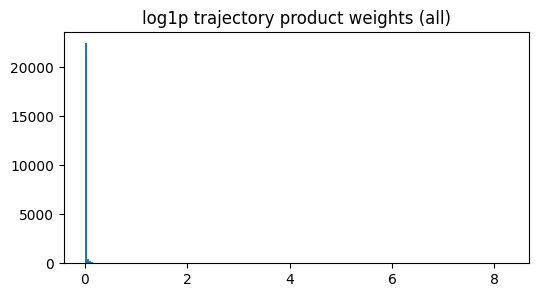

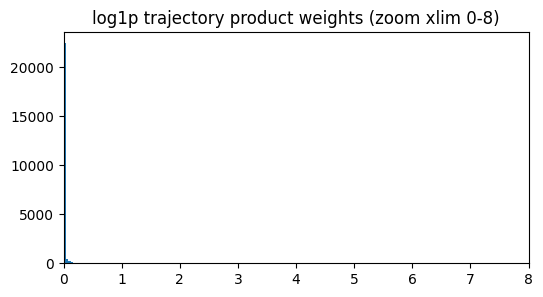

In [10]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
rec = pd.read_csv("/content/ope_crossfit_per_traj.csv")
w = rec["w_prod"].values
plt.figure(figsize=(6,3))
plt.hist(np.log1p(w), bins=200)
plt.title("log1p trajectory product weights (all)")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(np.log1p(w), bins=200)
plt.xlim(0,8)
plt.title("log1p trajectory product weights (zoom xlim 0-8)")
plt.show()


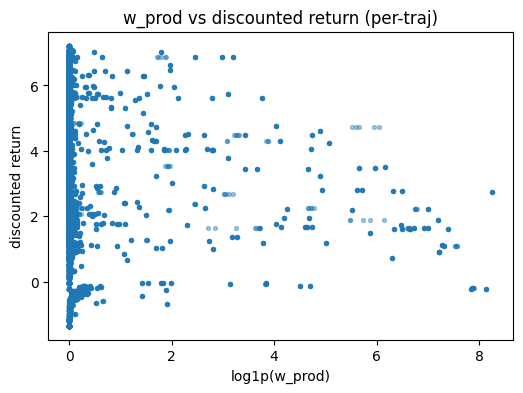

In [11]:
plt.figure(figsize=(6,4))
plt.scatter(np.log1p(rec["w_prod"].values), rec["disc_return"].values, s=8, alpha=0.4)
plt.xlabel("log1p(w_prod)")
plt.ylabel("discounted return")
plt.title("w_prod vs discounted return (per-traj)")
plt.show()


In [12]:
from sklearn.calibration import calibration_curve
import joblib, numpy as np, pandas as pd
cal_iso = joblib.load("/content/behavior_model_lgbm_statecols_ISO.pkl")

df = pd.read_csv("/content/final_traj_clean_training_heart_v2_sorted_imputed.csv", low_memory=False)
sample = df.sample(n=20000, random_state=42)
X = sample[bundle["state_cols"]].apply(pd.to_numeric, errors='coerce').fillna(0.0)
y = sample["action_mapped"].astype(int)
probs = cal_iso.predict_proba(X)

prob_pos = probs[:,0]
frac_pos, mean_pred = calibration_curve((y==0).astype(int), prob_pos, n_bins=10)
print("Calibration curve (action 0):")
print(list(zip(mean_pred, frac_pos)))



Calibration curve (action 0):
[(np.float64(0.29139786522010197), np.float64(0.0)), (np.float64(0.3945027472129443), np.float64(0.024875621890547265)), (np.float64(0.43674501290981416), np.float64(0.44537857685489995)), (np.float64(0.5437822583405352), np.float64(0.8333333333333334)), (np.float64(0.6235162468255815), np.float64(1.0))]


In [13]:
import pickle, joblib, numpy as np, pandas as pd
bundle = joblib.load("/content/policy_bundle.pkl")
state_cols = bundle["state_cols"]
behavior = bundle["models"]["behavior"]
q_models = bundle["models"]["q_models"]

df = pd.read_csv("/content/final_traj_clean_training_heart_v2_sorted_imputed.csv", low_memory=False)

rows = df.sample(5, random_state=42)
for _, r in rows.iterrows():
    S = r[state_cols].astype(float).fillna(0.0).values
    X = pd.DataFrame([S], columns=state_cols)
    b = behavior.predict_proba(X)[0]
    actions = sorted(list(q_models.keys()))
    q = np.array([q_models[a].predict(X.values)[0] for a in actions])
    from scipy.special import softmax
    pi = softmax(q/0.25)
    pi_mix = 0.8*b + 0.2*pi
    print("orig hadm,aug,timestep:", (r.hadm_id, r.aug_id, r.timestep))
    print("b:", b, "\nq:", q, "\npi_mix:", pi_mix)
    print("-"*40)


orig hadm,aug,timestep: (np.float64(192441.0), np.float64(1.0), np.float64(3.0))
b: [0.42968213 0.06465599 0.50566189] 
q: [4.18273522 4.84026112 4.34707101] 
pi_mix: [0.35564702 0.216858   0.42749498]
----------------------------------------
orig hadm,aug,timestep: (np.float64(169200.0), np.float64(4.0), np.float64(7.0))
b: [0.4372625  0.04034081 0.5223967 ] 
q: [2.33548719 2.41360692 2.2606516 ] 
pi_mix: [0.41415769 0.12022365 0.46561866]
----------------------------------------
orig hadm,aug,timestep: (np.float64(183549.0), np.float64(4.0), np.float64(4.0))
b: [0.43686214 0.04030183 0.52283603] 
q: [4.31102667 4.7898493  4.45527217] 
pi_mix: [0.3703893  0.1741269  0.45548381]
----------------------------------------
orig hadm,aug,timestep: (np.float64(121831.0), np.float64(3.0), np.float64(1.0))
b: [0.45200241 0.04786099 0.5001366 ] 
q: [5.80484803 6.59297785 6.03814828] 
pi_mix: [0.36902651 0.21198623 0.41898727]
----------------------------------------
orig hadm,aug,timestep: (np.

***Debugging***

In [14]:
import pickle, joblib, numpy as np, pandas as pd
from scipy.special import softmax


sequences = pickle.load(open("/content/rmab_sequences.pkl", "rb"))["sequences"]
bundle = joblib.load("/content/policy_bundle.pkl")

behavior = bundle["models"]["behavior"]
q_models = bundle["models"]["q_models"]
state_cols = bundle["state_cols"]


k_key = "(168931, 1)"

seq = sequences[eval(k_key)]
S = seq["S"]
A = np.array(seq["A"], int)
R = np.array(seq["R"], float)

actions = sorted(q_models.keys())

print("Trajectory length:", len(A))
print("-"*60)

for t in range(len(A)):
    X = pd.DataFrame([S[t]], columns=state_cols).fillna(0.0)

    b = behavior.predict_proba(X)[0]
    q = np.array([q_models[a].predict(X.values)[0] for a in actions])
    pi = softmax(q / 0.25)

    a = A[t]
    b_sel = max(b[a], 1e-12)
    pi_sel = max(pi[a], 1e-12)
    ratio = pi_sel / b_sel

    print(
        f"t={t:2d} | a={a} | "
        f"b_sel={b_sel:.2e} | pi_sel={pi_sel:.2e} | "
        f"ratio={ratio:.2f} | q={q}"
    )


Trajectory length: 8
------------------------------------------------------------
t= 0 | a=0 | b_sel=4.17e-01 | pi_sel=2.88e-01 | ratio=0.69 | q=[2.33548719 2.47204595 2.2606516 ]
t= 1 | a=0 | b_sel=4.17e-01 | pi_sel=2.88e-01 | ratio=0.69 | q=[2.33548719 2.47204595 2.2606516 ]
t= 2 | a=1 | b_sel=1.05e-01 | pi_sel=4.98e-01 | ratio=4.75 | q=[2.33548719 2.47204595 2.2606516 ]
t= 3 | a=1 | b_sel=1.05e-01 | pi_sel=4.98e-01 | ratio=4.75 | q=[2.33548719 2.47204595 2.2606516 ]
t= 4 | a=1 | b_sel=1.05e-01 | pi_sel=4.98e-01 | ratio=4.75 | q=[2.33548719 2.47204595 2.2606516 ]
t= 5 | a=1 | b_sel=1.05e-01 | pi_sel=4.98e-01 | ratio=4.75 | q=[2.33548719 2.47204595 2.2606516 ]
t= 6 | a=1 | b_sel=1.05e-01 | pi_sel=4.98e-01 | ratio=4.75 | q=[2.33548719 2.47204595 2.2606516 ]
t= 7 | a=0 | b_sel=4.17e-01 | pi_sel=2.88e-01 | ratio=0.69 | q=[2.33548719 2.47204595 2.2606516 ]


In [15]:
import pickle, joblib, numpy as np, pandas as pd
from scipy.special import softmax

sequences = pickle.load(open("/content/rmab_sequences.pkl", "rb"))["sequences"]
bundle = joblib.load("/content/policy_bundle.pkl")

behavior = bundle["models"]["behavior"]
q_models = bundle["models"]["q_models"]
state_cols = bundle["state_cols"]
actions = sorted(q_models.keys())

GAMMA = 0.95

def wis_for_cfg(temp=0.25, alpha=0.2, tau=0.0, clip=3.0):
    weights = []
    returns = []

    for seq in sequences.values():
        S = seq["S"]
        A = np.array(seq["A"], int)
        R = np.array(seq["R"], float)

        X = pd.DataFrame(S, columns=state_cols).fillna(0.0)
        b = behavior.predict_proba(X)                    # (T,K)
        q = np.vstack([q_models[a].predict(X.values) for a in actions]).T
        pi = softmax(q / temp, axis=1)

        # support truncation
        if tau > 0:
            mask = b < tau
            pi = np.where(mask, 0.0, pi)
            s = pi.sum(1, keepdims=True)
            pi = np.where(s > 0, pi/s, b)

        pi_mix = (1 - alpha) * b + alpha * pi

        idx = np.arange(len(A))
        b_sel = np.maximum(b[idx, A], 1e-12)
        pi_sel = np.maximum(pi_mix[idx, A], 1e-12)

        ratio = np.clip(pi_sel / b_sel, 0.0, clip)
        weights.append(np.prod(ratio))
        returns.append((GAMMA ** np.arange(len(R)) * R).sum())

    w = np.array(weights)
    r = np.array(returns)

    wis = (w * r).sum() / (w.sum() + 1e-12)
    ess = (w.sum() ** 2) / (np.sum(w ** 2) + 1e-12)

    return wis, ess

configs = [
    dict(temp=0.25, alpha=0.2, tau=0.0, clip=3.0),
    dict(temp=0.25, alpha=0.4, tau=0.01, clip=3.0),
    dict(temp=0.25, alpha=0.4, tau=0.01, clip=2.0),
    dict(temp=0.25, alpha=0.6, tau=0.01, clip=1.5),
]

for cfg in configs:
    w, e = wis_for_cfg(**cfg)
    print(cfg, "→ WIS:", round(w, 3), "ESS:", round(e, 1))


{'temp': 0.25, 'alpha': 0.2, 'tau': 0.0, 'clip': 3.0} → WIS: 4.876 ESS: 912.5
{'temp': 0.25, 'alpha': 0.4, 'tau': 0.01, 'clip': 3.0} → WIS: 3.809 ESS: 823.8
{'temp': 0.25, 'alpha': 0.4, 'tau': 0.01, 'clip': 2.0} → WIS: 3.362 ESS: 1251.9
{'temp': 0.25, 'alpha': 0.6, 'tau': 0.01, 'clip': 1.5} → WIS: 2.315 ESS: 1258.4


In [16]:
import pandas as pd

df = pd.read_csv("/content/final_traj_clean_training_heart_v2_sorted_imputed.csv", low_memory=False)

# how many augmentations per patient?
aug_counts = (
    df.groupby(["hadm_id", "aug_id"])
      .size()
      .groupby("hadm_id")
      .count()
      .sort_values(ascending=False)
)

print("Top hadm_ids by number of augmentations:")
print(aug_counts.head(20))


h = 168931
sub = df[df.hadm_id == h].sort_values(["aug_id", "timestep"])
print(sub.head(40))


Top hadm_ids by number of augmentations:
hadm_id
199986    5
100009    5
100031    5
100041    5
100045    5
100060    5
100103    5
100114    5
100131    5
100147    5
100160    5
100161    5
100182    5
100191    5
100195    5
199732    5
199727    5
199724    5
199715    5
199714    5
dtype: int64
        hadm_id  timestep  aug_id  action          hr         rr       spo2  \
137080   168931         0       1       0  132.666667  24.333333  99.666667   
137081   168931         1       1       0  132.666667  24.333333  99.666667   
137082   168931         2       1       1  132.666667  24.333333  99.666667   
137083   168931         3       1       1  132.666667  24.333333  99.666667   
137084   168931         4       1       1  132.666667  24.333333  99.666667   
137085   168931         5       1       1  132.666667  24.333333  99.666667   
137086   168931         6       1       1  132.666667  24.333333  99.666667   
137087   168931         7       1       0  132.666667  24.333333  

In [17]:
import pickle, numpy as np, pandas as pd

sequences = pickle.load(open("/content/rmab_sequences.pkl","rb"))["sequences"]

# Choosing hadm to inspect from previous output
hid = 168931
# Collecting S,A,R per aug

augs = sorted([k for k in sequences.keys() if k[0]==hid])
print("augs:", augs)
for k in augs:
    seq = sequences[k]
    S = np.asarray(seq["S"])
    A = np.asarray(seq["A"])
    R = np.asarray(seq["R"])
    print(k, "shapes:", S.shape, A.shape, R.shape)


from itertools import combinations
for k1, k2 in combinations(augs,2):
    s1, s2 = sequences[k1]["S"], sequences[k2]["S"]
    a1, a2 = sequences[k1]["A"], sequences[k2]["A"]
    r1, r2 = sequences[k1]["R"], sequences[k2]["R"]
    same = (np.allclose(np.asarray(s1), np.asarray(s2)) and
            np.array_equal(np.asarray(a1), np.asarray(a2)) and
            np.allclose(np.asarray(r1), np.asarray(r2)))
    print(f"{k1} vs {k2} identical? {same}")


augs: [(168931, 1), (168931, 2), (168931, 3), (168931, 4), (168931, 5)]
(168931, 1) shapes: (8, 20) (8,) (8,)
(168931, 2) shapes: (8, 20) (8,) (8,)
(168931, 3) shapes: (8, 20) (8,) (8,)
(168931, 4) shapes: (8, 20) (8,) (8,)
(168931, 5) shapes: (8, 20) (8,) (8,)
(168931, 1) vs (168931, 2) identical? True
(168931, 1) vs (168931, 3) identical? True
(168931, 1) vs (168931, 4) identical? True
(168931, 1) vs (168931, 5) identical? True
(168931, 2) vs (168931, 3) identical? True
(168931, 2) vs (168931, 4) identical? True
(168931, 2) vs (168931, 5) identical? True
(168931, 3) vs (168931, 4) identical? True
(168931, 3) vs (168931, 5) identical? True
(168931, 4) vs (168931, 5) identical? True


##**Stability Analysis & OPE Diagnostics**


In [18]:
# Run once
import json, pickle, joblib, numpy as np, pandas as pd
from pathlib import Path
from scipy.special import softmax

BASE = Path("/content")
assert BASE.exists()


RMAB_PKL = BASE / "rmab_sequences.pkl"
CLEAN_CSV = BASE / "final_traj_clean_training_heart_v2_sorted_imputed.csv"
BHV_ISO_PKL = BASE / "behavior_model_lgbm_statecols_ISO.pkl"
BHV_PROBS = BASE / "behavior_propensity_probs_statecols.npy"
Q_MODELS_PKL = BASE / "q_models_fqe_strong.pkl"

print("Files present:")
for p in (RMAB_PKL, CLEAN_CSV, BHV_ISO_PKL, BHV_PROBS, Q_MODELS_PKL):
    print(" -", p.name, ":", "exists" if p.exists() else "MISSING")


Files present:
 - rmab_sequences.pkl : exists
 - final_traj_clean_training_heart_v2_sorted_imputed.csv : exists
 - behavior_model_lgbm_statecols_ISO.pkl : exists
 - behavior_propensity_probs_statecols.npy : exists
 - q_models_fqe_strong.pkl : MISSING


In [19]:
with open(RMAB_PKL, "rb") as f:
    data = pickle.load(f)
state_cols = data["state_cols"]
sequences = data["sequences"]

print("state dim:", len(state_cols))
print("n trajectories:", len(sequences))


sample_key = next(iter(sequences))
S = sequences[sample_key]["S"]
A = sequences[sample_key]["A"]
R = sequences[sample_key]["R"]
print("sample shapes:", S.shape, A.shape, R.shape)


state dim: 20
n trajectories: 24635
sample shapes: (8, 20) (8,) (8,)


In [20]:
behavior = joblib.load(BHV_ISO_PKL)
probs = np.load(str(BHV_PROBS), allow_pickle=False)
print("behavior.classes_:", getattr(behavior, "classes_", None))
print("propensities shape:", probs.shape)


behavior.classes_: [0 1 2]
propensities shape: (197080, 3)


In [23]:
# Finding hadm_ids with many augmentations

df = pd.read_csv(CLEAN_CSV, low_memory=False)
counts = df.groupby("hadm_id")["aug_id"].nunique().sort_values(ascending=False).head(30)
print("Top hadm augment counts:\n", counts)


hid = 168931
grouped = df[df.hadm_id==hid].sort_values(["aug_id","timestep"])
print("augs:", sorted(grouped.aug_id.unique()))
for aug in sorted(grouped.aug_id.unique()):
    sub = grouped[grouped.aug_id==aug].sort_values("timestep")
    Scols = state_cols
    Sarr = sub[Scols].to_numpy()
    Aarr = sub["action_mapped"].to_numpy()
    Rarr = sub["reward"].to_numpy() if "reward" in sub.columns else None
    print((hid,aug), "shapes:", Sarr.shape, Aarr.shape, Rarr.shape if Rarr is not None else None)


augs = sorted(grouped.aug_id.unique())
arrays = []
for aug in augs:
    sub = grouped[grouped.aug_id==aug].sort_values("timestep")
    arrays.append((sub[state_cols].to_numpy(), sub["action_mapped"].to_numpy(),
                   sub["reward"].to_numpy() if "reward" in sub.columns else None))
for i in range(len(augs)):
    for j in range(i+1, len(augs)):
        sameS = np.array_equal(arrays[i][0], arrays[j][0])
        sameA = np.array_equal(arrays[i][1], arrays[j][1])
        sameR = True if (arrays[i][2] is None or arrays[j][2] is None) else np.array_equal(arrays[i][2], arrays[j][2])
        print(f"({hid},{augs[i]}) vs ({hid},{augs[j]}) identical? S:{sameS} A:{sameA} R:{sameR}")


Top hadm augment counts:
 hadm_id
199986    5
100009    5
100031    5
100041    5
100045    5
100060    5
100103    5
100114    5
100131    5
100147    5
100160    5
100161    5
100182    5
100191    5
100195    5
199732    5
199727    5
199724    5
199715    5
199714    5
199603    5
199598    5
199591    5
199585    5
199579    5
199574    5
199546    5
199544    5
199484    5
199445    5
Name: aug_id, dtype: int64
augs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
(168931, np.int64(1)) shapes: (8, 20) (8,) None
(168931, np.int64(2)) shapes: (8, 20) (8,) None
(168931, np.int64(3)) shapes: (8, 20) (8,) None
(168931, np.int64(4)) shapes: (8, 20) (8,) None
(168931, np.int64(5)) shapes: (8, 20) (8,) None
(168931,1) vs (168931,2) identical? S:True A:True R:True
(168931,1) vs (168931,3) identical? S:True A:True R:True
(168931,1) vs (168931,4) identical? S:True A:True R:True
(168931,1) vs (168931,5) identical? S:True A:True R:True
(168931,2) vs (168931,3) identical? S:T

***Dedupe***

In [24]:

import pickle, joblib, numpy as np, pandas as pd, time
from collections import Counter
from scipy.special import softmax


RMAB_PKL = "/content/rmab_sequences.pkl"
BUNDLE_PKL = "/content/policy_bundle.pkl"
CLEAN_CSV = "/content/final_traj_clean_training_heart_v2_sorted_imputed.csv"

print("Loading files...")
sequences = pickle.load(open(RMAB_PKL, "rb"))["sequences"]
bundle = joblib.load(BUNDLE_PKL)
behavior = bundle["models"]["behavior"]
q_models = bundle["models"]["q_models"]
state_cols = bundle["state_cols"]
actions = sorted(list(q_models.keys()))
print("n_sequences (orig):", len(sequences))


GAMMA = 0.95

def compute_wis_ess(seq_dict, temp=0.25, alpha=0.2, tau=0.0, clip=3.0):
    weights = []
    returns = []
    for k, seq in seq_dict.items():
        S = seq["S"]
        A = np.array(seq["A"], int)
        R = np.array(seq["R"], float)
        X = pd.DataFrame(S, columns=state_cols).fillna(0.0)
        b = behavior.predict_proba(X)    # (T,K)
        q = np.vstack([q_models[a].predict(X.values) for a in actions]).T
        pi = softmax(q / temp, axis=1)
        if tau > 0:
            mask = b < tau
            pi = np.where(mask, 0.0, pi)
            s = pi.sum(1, keepdims=True)
            pi = np.where(s>0, pi/s, b)
        pi_mix = (1.0 - alpha) * b + alpha * pi
        idx = np.arange(len(A))
        b_sel = np.maximum(b[idx, A], 1e-12)
        pi_sel = np.maximum(pi_mix[idx, A], 1e-12)
        ratio = np.clip(pi_sel / b_sel, 0.0, clip)
        weights.append(float(np.prod(ratio)))
        returns.append(float((GAMMA ** np.arange(len(R)) * R).sum()))
    w = np.array(weights, dtype=float)
    r = np.array(returns, dtype=float)
    wis = float((w * r).sum() / (w.sum() + 1e-12))
    ess = float((w.sum() ** 2) / (np.sum(w ** 2) + 1e-12)) if w.size>0 else 0.0
    behavior_value = float(r.mean())
    return wis, ess, behavior_value, w, r


chosen = {}
for (hid, aug) in sequences.keys():
    if hid not in chosen or aug < chosen[hid][0]:
        chosen[hid] = (aug, sequences[(hid, aug)])
seq_dedup = { (hid, aug): seq for hid,(aug,seq) in chosen.items() }
print("n_sequences (dedup):", len(seq_dedup))


grid = [
    {"temp":0.25, "alpha":0.2, "tau":0.0, "clip":3.0},
    {"temp":0.25, "alpha":0.4, "tau":0.01, "clip":3.0},
    {"temp":0.25, "alpha":0.4, "tau":0.01, "clip":2.0},
    {"temp":0.25, "alpha":0.6, "tau":0.01, "clip":1.5},
]

rows = []
t0 = time.time()
for cfg in grid:
    wis_o, ess_o, beh_o, w_o, r_o = compute_wis_ess(sequences, **cfg)
    wis_d, ess_d, beh_d, w_d, r_d = compute_wis_ess(seq_dedup, **cfg)
    rows.append({
        **cfg,
        "wis_orig": wis_o, "ess_orig": ess_o,
        "wis_dedup": wis_d, "ess_dedup": ess_d,
        "behavior_orig": beh_o, "behavior_dedup": beh_d,
        "n_orig": len(sequences), "n_dedup": len(seq_dedup)
    })
    print(cfg, "-> orig(WIS,ESS)=", round(wis_o,4), round(ess_o,1),
          "dedup(WIS,ESS)=", round(wis_d,4), round(ess_d,1))
print("Done in", round(time.time()-t0,1), "s")


df_res = pd.DataFrame(rows)
out_csv = "/content/wis_dedup_results.csv"
df_res.to_csv(out_csv, index=False)
print("Saved results to", out_csv)
print(df_res)


print("\nTop 10 trajectories by w_prod (orig):")
wprod = w_o if 'w_o' in locals() else None


keys = list(sequences.keys())
df_off = pd.DataFrame({
    "key": [str(k) for k in keys],
    "w_prod": w_o,
    "disc_return": r_o
})
print(df_off.sort_values("w_prod", ascending=False).head(10))


Loading files...
n_sequences (orig): 24635
n_sequences (dedup): 4927
{'temp': 0.25, 'alpha': 0.2, 'tau': 0.0, 'clip': 3.0} -> orig(WIS,ESS)= 4.8758 912.5 dedup(WIS,ESS)= 4.8719 182.9
{'temp': 0.25, 'alpha': 0.4, 'tau': 0.01, 'clip': 3.0} -> orig(WIS,ESS)= 3.8087 823.8 dedup(WIS,ESS)= 3.8058 164.8
{'temp': 0.25, 'alpha': 0.4, 'tau': 0.01, 'clip': 2.0} -> orig(WIS,ESS)= 3.3619 1251.9 dedup(WIS,ESS)= 3.3619 250.3
{'temp': 0.25, 'alpha': 0.6, 'tau': 0.01, 'clip': 1.5} -> orig(WIS,ESS)= 2.3151 1258.4 dedup(WIS,ESS)= 2.3148 251.4
Done in 603.3 s
Saved results to /content/wis_dedup_results.csv
   temp  alpha   tau  clip  wis_orig     ess_orig  wis_dedup   ess_dedup  \
0  0.25    0.2  0.00   3.0  4.875768   912.464440   4.871921  182.880057   
1  0.25    0.4  0.01   3.0  3.808715   823.779128   3.805832  164.821943   
2  0.25    0.4  0.01   2.0  3.361941  1251.932683   3.361946  250.272416   
3  0.25    0.6  0.01   1.5  2.315098  1258.428098   2.314793  251.425874   

   behavior_orig  behavio

In [25]:

grid = [
  {"temp":0.25, "alpha":0.22, "tau":0.01, "clip":3.0},
  {"temp":0.25, "alpha":0.25, "tau":0.01, "clip":3.0},
  {"temp":0.25, "alpha":0.30, "tau":0.01, "clip":3.0},
  {"temp":0.25, "alpha":0.30, "tau":0.01, "clip":2.5},
  {"temp":0.25, "alpha":0.35, "tau":0.01, "clip":2.5},
]
# compute wis,ess on seq_dedup (using compute_wis_ess function from before)

for cfg in grid:
    wis, ess, beh, *_ = compute_wis_ess(seq_dedup, **cfg)
    print(cfg, "-> WIS:", round(wis,4), "ESS:", int(ess), "behavior:", round(beh,4))


{'temp': 0.25, 'alpha': 0.22, 'tau': 0.01, 'clip': 3.0} -> WIS: 4.7456 ESS: 188 behavior: 3.7365
{'temp': 0.25, 'alpha': 0.25, 'tau': 0.01, 'clip': 3.0} -> WIS: 4.5763 ESS: 192 behavior: 3.7365
{'temp': 0.25, 'alpha': 0.3, 'tau': 0.01, 'clip': 3.0} -> WIS: 4.3155 ESS: 188 behavior: 3.7365
{'temp': 0.25, 'alpha': 0.3, 'tau': 0.01, 'clip': 2.5} -> WIS: 3.9446 ESS: 225 behavior: 3.7365
{'temp': 0.25, 'alpha': 0.35, 'tau': 0.01, 'clip': 2.5} -> WIS: 3.7554 ESS: 204 behavior: 3.7365


In [26]:

import pickle, joblib, numpy as np, pandas as pd, time
from scipy.special import softmax
from collections import Counter


RMAB_PKL = "/content/rmab_sequences.pkl"
BUNDLE_PKL = "/content/policy_bundle.pkl"

print("Loading...")
sequences = pickle.load(open(RMAB_PKL, "rb"))["sequences"]
bundle = joblib.load(BUNDLE_PKL)
behavior = bundle["models"]["behavior"]
q_models = bundle["models"]["q_models"]
state_cols = bundle["state_cols"]
actions = sorted(list(q_models.keys()))

# Building deduped sequences

chosen = {}
for (hid, aug) in sequences.keys():
    if hid not in chosen or aug < chosen[hid][0]:
        chosen[hid] = (aug, sequences[(hid, aug)])
seq_dedup = { (hid, aug): seq for hid,(aug,seq) in chosen.items() }
print("n orig:", len(sequences), "n dedup:", len(seq_dedup))

# Chosen config -- FINAL

CFG = {"temp":0.25, "alpha":0.30, "tau":0.01, "clip":2.5}
GAMMA = 0.95

# Computing per-traj w_prod and disc_return
keys = list(seq_dedup.keys())
W = np.zeros(len(keys), dtype=float)
R = np.zeros(len(keys), dtype=float)

for i,k in enumerate(keys):
    seq = seq_dedup[k]
    S = seq["S"]
    A = np.array(seq["A"], int)
    RR = np.array(seq["R"], float)
    X = pd.DataFrame(S, columns=state_cols).fillna(0.0)
    b = behavior.predict_proba(X)
    q = np.vstack([q_models[a].predict(X.values) for a in actions]).T
    pi = softmax(q / CFG["temp"], axis=1)
    if CFG["tau"] > 0:
        mask = b < CFG["tau"]
        pi = np.where(mask, 0.0, pi)
        s = pi.sum(1, keepdims=True)
        pi = np.where(s>0, pi/s, b)
    pi_mix = (1.0 - CFG["alpha"]) * b + CFG["alpha"] * pi
    idx = np.arange(len(A))
    b_sel = np.maximum(b[idx, A], 1e-12)
    pi_sel = np.maximum(pi_mix[idx, A], 1e-12)
    ratio = np.clip(pi_sel / b_sel, 0.0, CFG["clip"])
    W[i] = float(np.prod(ratio))
    R[i] = float((GAMMA ** np.arange(len(RR)) * RR).sum())

# Quick check

print("Sample W (head):", W[:8])
print("Sample R (head):", R[:8])

# Computing point estimate (WIS)

V_wis = (W * R).sum() / (W.sum() + 1e-12)
ess = (W.sum()**2) / (np.sum(W**2) + 1e-12)
print("\nPoint estimate (WIS):", V_wis, "ESS:", ess)

# Bootstrap CI

B = 1000
rng = np.random.default_rng(42)
bs_vals = np.empty(B)
n = len(W)
t0 = time.time()
for b_i in range(B):
    idx = rng.integers(0, n, n)
    w_s = W[idx]; r_s = R[idx]
    bs_vals[b_i] = (w_s * r_s).sum() / (w_s.sum() + 1e-12)
ci_low, ci_high = np.percentile(bs_vals, [2.5, 97.5])
print(f"Bootstrap {B} CI for WIS: [{ci_low:.4f}, {ci_high:.4f}] (mean {bs_vals.mean():.4f})")
print("Elapsed:", round(time.time()-t0,1), "s")

# Saving results

out = {"cfg":CFG, "wis": float(V_wis), "ess": float(ess), "ci":[float(ci_low), float(ci_high)], "n_dedup": n}
pd.DataFrame([out]).to_csv("/content/wis_chosen_bootstrap.csv", index=False)
print("Saved /content/wis_chosen_bootstrap.csv")


Loading...
n orig: 24635 n dedup: 4927
Sample W (head): [0.13045686 0.12442067 0.12109702 0.12423842 0.11668796 0.12020244
 0.17087902 0.16510654]
Sample R (head): [2.85512534 2.75843951 3.14425778 2.67021407 3.32475778 2.56843951
 2.75843951 3.42807194]

Point estimate (WIS): 3.944551738416058 ESS: 225.12750229549948
Bootstrap 1000 CI for WIS: [3.6513, 4.2192] (mean 3.9426)
Elapsed: 0.0 s
Saved /content/wis_chosen_bootstrap.csv


## **Plots and Insights**

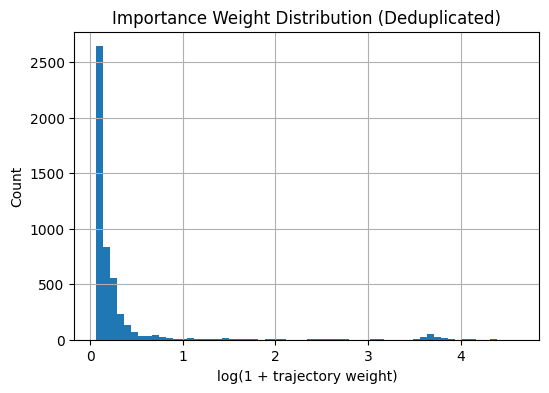

In [27]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(6,4))
plt.hist(np.log1p(W), bins=60)
plt.xlabel("log(1 + trajectory weight)")
plt.ylabel("Count")
plt.title("Importance Weight Distribution (Deduplicated)")
plt.grid(True)
plt.show()


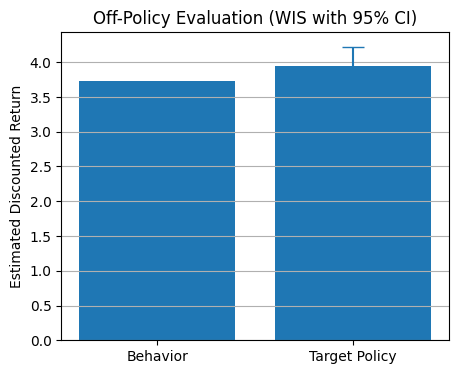

In [28]:
behavior = 3.736483
wis = 3.9445517
ci_low, ci_high = 3.6513, 4.2192

plt.figure(figsize=(5,4))
plt.bar(["Behavior", "Target Policy"], [behavior, wis])
plt.errorbar(["Target Policy"], [wis],
             yerr=[[wis - ci_low], [ci_high - wis]],
             fmt="none", capsize=8)

plt.ylabel("Estimated Discounted Return")
plt.title("Off-Policy Evaluation (WIS with 95% CI)")
plt.grid(True, axis="y")
plt.show()


In [29]:
import pandas as pd

df_top = pd.DataFrame({
    "traj_key": list(seq_dedup.keys()),
    "weight": W,
    "return": R
}).sort_values("weight", ascending=False).head(10)

df_top


,traj_key,weight,return
1445,"(128758, 1)",100.471905,-0.204163
1495,"(129687, 1)",91.420197,-0.204163
3061,"(161712, 1)",83.324571,1.111150
3066,"(161807, 1)",82.359981,1.078885
2224,"(144420, 1)",78.273924,1.891521
592,"(111717, 1)",76.563709,0.900954
580,"(111426, 1)",76.038587,0.900954
1552,"(130931, 1)",69.885541,-0.214908
3897,"(179050, 1)",69.479799,2.233401
1922,"(138417, 1)",67.084603,1.616955


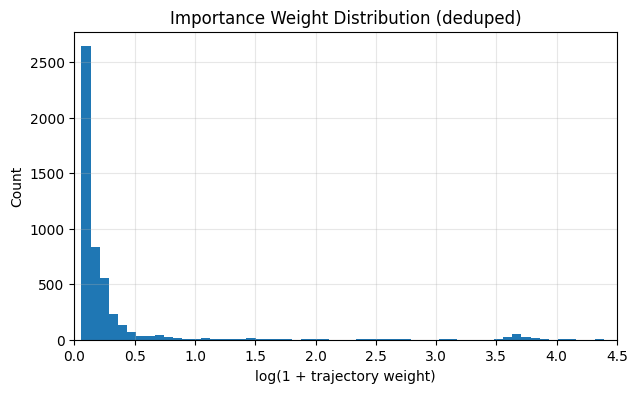

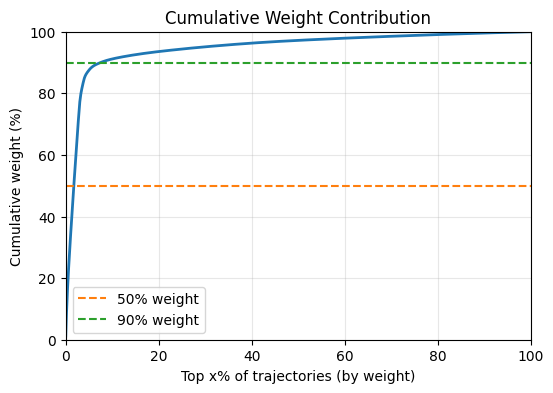

87 trajs (~1.77%) cover 50% of total weight
371 trajs (~7.53%) cover 90% of total weight


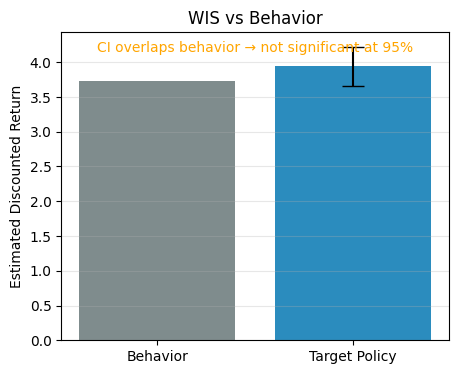

,traj_key,weight,disc_return
0,"(128758, 1)",100.471905,-0.204163
1,"(129687, 1)",91.420197,-0.204163
2,"(161712, 1)",83.324571,1.111150
3,"(161807, 1)",82.359981,1.078885
4,"(144420, 1)",78.273924,1.891521
5,"(111717, 1)",76.563709,0.900954
6,"(111426, 1)",76.038587,0.900954
7,"(130931, 1)",69.885541,-0.214908
8,"(179050, 1)",69.479799,2.233401
9,"(138417, 1)",67.084603,1.616955


In [34]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import gaussian_kde



# 1) Weight histogram
plt.figure(figsize=(7,4))
vals = np.log1p(W)
plt.hist(vals, bins=60)
plt.xlabel("log(1 + trajectory weight)")
plt.ylabel("Count")
plt.title("Importance Weight Distribution (deduped)")
plt.grid(True, alpha=0.3)
plt.xlim(0, 4.5)
plt.show()

# 2) Cumulative share of weight (how many trajectories carry most weight)

sorted_idx = np.argsort(W)[::-1]
cumw = np.cumsum(W[sorted_idx]) / (W.sum() + 1e-12)
pct_traj = np.arange(1, len(W)+1) / len(W) * 100

plt.figure(figsize=(6,4))
plt.plot(pct_traj, cumw*100, lw=2)
plt.axhline(50, color='C1', linestyle='--', label='50% weight')
plt.axhline(90, color='C2', linestyle='--', label='90% weight')
plt.xlabel("Top x% of trajectories (by weight)")
plt.ylabel("Cumulative weight (%)")
plt.title("Cumulative Weight Contribution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

# No. of trajectories cover 50% and 90%

n50 = np.searchsorted(cumw, 0.50) + 1
n90 = np.searchsorted(cumw, 0.90) + 1
print(f"{n50} trajs (~{n50/len(W)*100:.2f}%) cover 50% of total weight")
print(f"{n90} trajs (~{n90/len(W)*100:.2f}%) cover 90% of total weight")

# 3) WIS vs Behavior

plt.figure(figsize=(5,4))
plt.bar([0,1], [behavior, wis], color=['#7f8c8d','#2b8cbe'])
plt.errorbar([1], [wis], yerr=[[wis-ci_low],[ci_high-wis]], fmt='none', capsize=8, color='k')
plt.xticks([0,1], ["Behavior", "Target Policy"])
plt.ylabel("Estimated Discounted Return")
plt.title("WIS vs Behavior")
plt.grid(axis='y', alpha=0.3)
# annotate significance note
if ci_low > behavior:
    plt.text(0.5, max(wis, behavior)+0.2, "95% CI > behavior → significant", ha='center', color='g')
else:
    plt.text(0.5, max(wis, behavior)+0.2, "CI overlaps behavior → not significant at 95%", ha='center', color='orange')
plt.show()

# 4) Top-weighted trajectories table

df_top = pd.DataFrame({
    "traj_key": list(seq_dedup.keys()),
    "weight": W,
    "disc_return": R
}).sort_values("weight", ascending=False).head(10).reset_index(drop=True)
display(df_top)


Observed WIS - behavior = 0.2081
One-sided p (WIS <= behavior): 0.0665
Two-sided p: 0.522


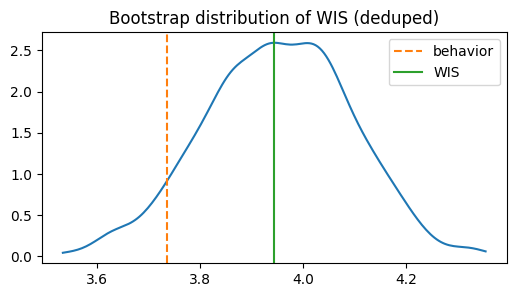

In [31]:
# Bootstrap p-value: proportion of bootstrap WIS samples ≤ behavior (one-sided)
B = 2000
rng = np.random.default_rng(123)
n = len(W)
bs_vals = np.empty(B)
for i in range(B):
    idx = rng.integers(0, n, n)
    w_s = W[idx]; r_s = R[idx]
    bs_vals[i] = (w_s * r_s).sum() / (w_s.sum() + 1e-12)

# p-value (one-sided: how often WIS <= behavior)
p_one_sided = np.mean(bs_vals <= behavior)
# two-sided: how often abs(diff) >= observed abs diff
obs_diff = wis - behavior
p_two_sided = np.mean(np.abs(bs_vals - behavior) >= abs(obs_diff))

print("Observed WIS - behavior = %.4f" % obs_diff)
print("One-sided p (WIS <= behavior):", p_one_sided)
print("Two-sided p:", p_two_sided)

# plot bootstrap density
plt.figure(figsize=(6,3))
k = gaussian_kde(bs_vals)
xs = np.linspace(min(bs_vals), max(bs_vals), 200)
plt.plot(xs, k(xs))
plt.axvline(behavior, color='C1', linestyle='--', label='behavior')
plt.axvline(wis, color='C2', linestyle='-', label='WIS')
plt.legend()
plt.title("Bootstrap distribution of WIS (deduped)")
plt.show()


In [32]:

N = 5
top_keys = df_top['traj_key'].tolist()[:N]
for k in top_keys:
    print("=== traj", k, "===")
    seq = seq_dedup[eval(k)] if isinstance(k, str) else seq_dedup[k]
    print("len:", len(seq['A']))
    print("A:", seq['A'])
    print("R:", seq['R'])
    s_df = pd.DataFrame(seq['S'], columns=state_cols)
    display(s_df)


=== traj (128758, 1) ===
len: 8
A: [0 0 1 1 1 1 1 0]
R: [ 0.    0.   -0.05 -0.05 -0.05 -0.05 -0.05  0.  ]


,hr,rr,spo2,sbp,dbp,mbp,si,pp,lactate,creatinine,hemoglobin,ts_lactate,ts_creatinine,ts_hemoglobin,lactate_present,creatinine_present,hemoglobin_present,lactate_imputed,creatinine_imputed,hemoglobin_imputed
0,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,3.2,7.4,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


=== traj (129687, 1) ===
len: 8
A: [0 0 1 1 1 1 1 0]
R: [ 0.    0.   -0.05 -0.05 -0.05 -0.05 -0.05  0.  ]


,hr,rr,spo2,sbp,dbp,mbp,si,pp,lactate,creatinine,hemoglobin,ts_lactate,ts_creatinine,ts_hemoglobin,lactate_present,creatinine_present,hemoglobin_present,lactate_imputed,creatinine_imputed,hemoglobin_imputed
0,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,13.300000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,13.300000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,13.300000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,13.300000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,13.300000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,13.300000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,13.114056,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0
7,118.25,22.75,97.0,78.75,36.25,50.416675,1.501587,42.5,9.0,8.4,14.022197,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0


=== traj (161712, 1) ===
len: 8
A: [0 0 0 1 1 1 1 1]
R: [0.19387755 0.19387755 0.19387755 0.14387755 0.14387755 0.14387755
 0.14387755 0.14387755]


,hr,rr,spo2,sbp,dbp,mbp,si,pp,lactate,creatinine,hemoglobin,ts_lactate,ts_creatinine,ts_hemoglobin,lactate_present,creatinine_present,hemoglobin_present,lactate_imputed,creatinine_imputed,hemoglobin_imputed
0,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,13.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


=== traj (161807, 1) ===
len: 8
A: [1 1 1 1 1 0 0 0]
R: [0.14387755 0.14387755 0.14387755 0.14387755 0.14387755 0.19387755
 0.19387755 0.19387755]


,hr,rr,spo2,sbp,dbp,mbp,si,pp,lactate,creatinine,hemoglobin,ts_lactate,ts_creatinine,ts_hemoglobin,lactate_present,creatinine_present,hemoglobin_present,lactate_imputed,creatinine_imputed,hemoglobin_imputed
0,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,128.0,25.0,98.0,98.0,47.0,64.0,1.306122,51.0,5.1,5.2,8.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


=== traj (144420, 1) ===
len: 8
A: [0 0 1 1 1 1 1 0]
R: [0.31132075 0.31132075 0.26132075 0.26132075 0.26132075 0.26132075
 0.26132075 0.31132075]


,hr,rr,spo2,sbp,dbp,mbp,si,pp,lactate,creatinine,hemoglobin,ts_lactate,ts_creatinine,ts_hemoglobin,lactate_present,creatinine_present,hemoglobin_present,lactate_imputed,creatinine_imputed,hemoglobin_imputed
0,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,126.0,18.0,99.5,106.0,45.0,79.0,1.188679,61.0,11.4,6.9,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
